# Book Recommendation System

This notebook presents a book recommendation system designed to suggest personalized recommendations based on user preferences and book attributes. The system leverages a combination of techniques, including exploratory data analysis (EDA), feature engineering, fuzzy matching, and K-nearest neighbors (KNN) for recommendation generation.

The notebook uses books.csv as the dataset; this is a clean dataset sourced from Kaggle, contains book attributes taken from Goodreads.
https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks

Limitations: The system cannot deal with books not included in the dataset.

In [98]:
!pip install beautifulsoup4
!pip install seaborn
!pip install scikit-learn
!pip install fuzzywuzzy[speedup]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from fuzzywuzzy import process
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Dataset



In [11]:
#read dataset

df = pd.read_csv('books.csv', on_bad_lines = 'skip')
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## EDA

Now that we know what our data looks like, let’s go ahead and find all the null values present in our data.

In [12]:
df.isnull().sum()

,0
bookID,0
title,0
authors,0
average_rating,0
isbn,0
isbn13,0
language_code,0
num_pages,0
ratings_count,0
text_reviews_count,0


In [13]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


From the results above, we can see that our ratings are all between 0 and 5.

Text(0.5, 1.0, 'Average Rating of the Top Ten Books')

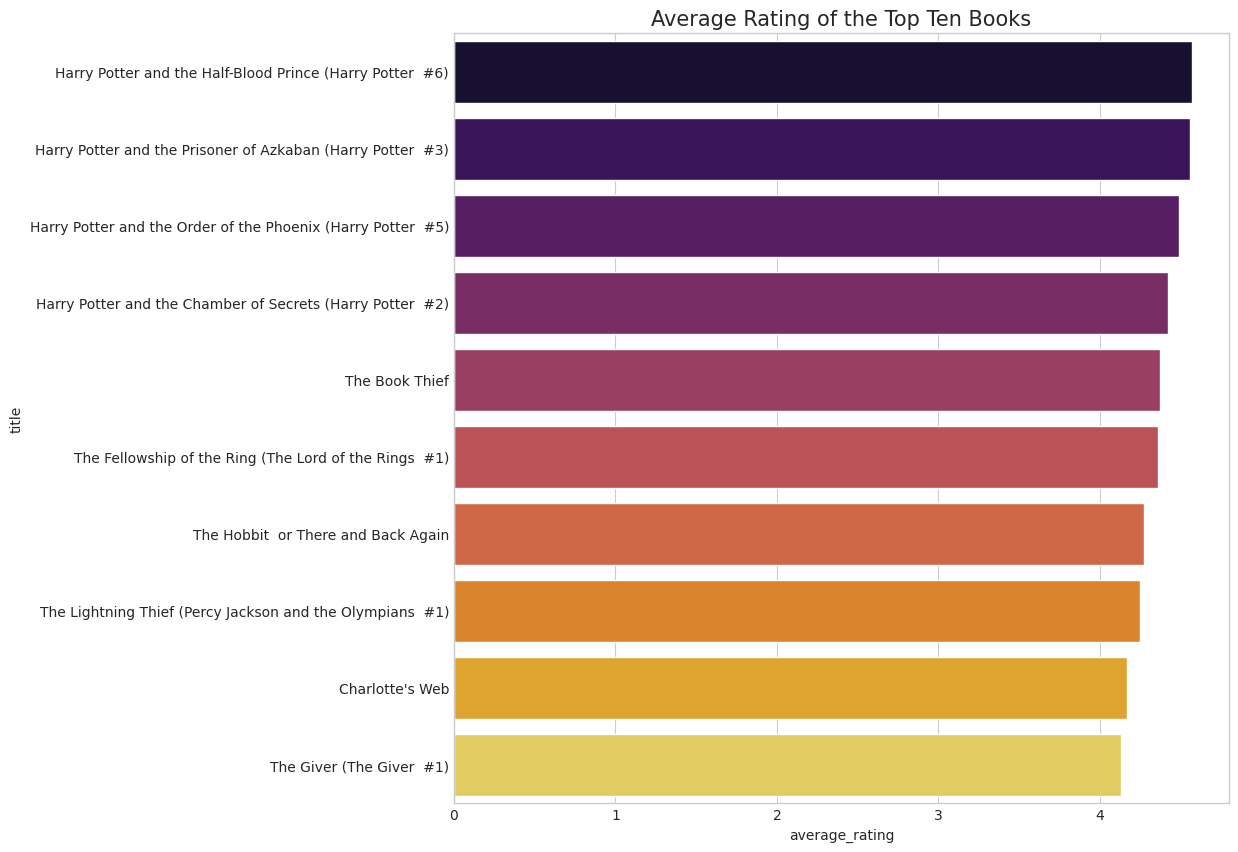

In [94]:
#average rating of the top 10 books barplot

#calculate top 10 and filter
top_ten = df[df['ratings_count'] > 1000000]
top_ten = top_ten.sort_values(by='average_rating', ascending=False)

#plot with seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
data = top_ten.sort_values(by='average_rating', ascending=False).head(10)
sns.barplot(x="average_rating", y="title", data=data, palette='inferno', hue="title", legend=False)
plt.title("Average Rating of the Top Ten Books",fontsize = 15)

Although the maximum possible score is 5.0, none of the books in our have achieved this rating. We have filtered them to ensure that all included books have a decent number of ratings. This filtering helps to avoid books with only a few ratings that might have been given a perfect score by chance.

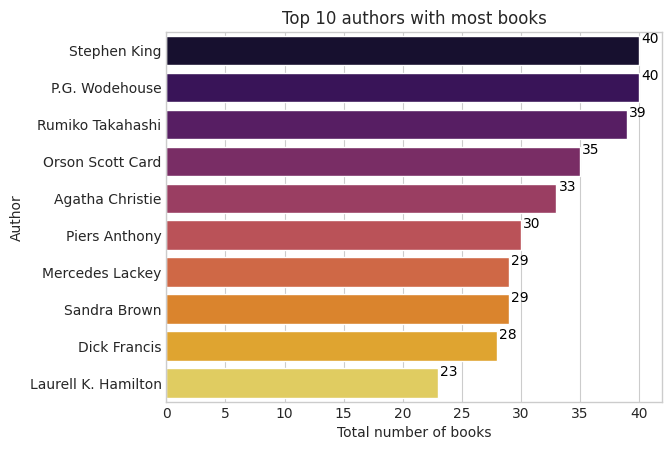

In [43]:
#top 10 authors with the most books

#calculate and plot
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
ax = sns.barplot(x='title', y='authors', data=most_books, palette='inferno', hue="authors", legend=False)

#title and labels
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
ax.set_ylabel("Author")

#adding text annotations with the count on each bar
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width() + .2, i.get_y() + .2, str(round(i.get_width())), fontsize=10, color='black')

plt.show()

From the above chart, we can see that Stephen King and P.G. Wodehouse have the most books in the dataset. Both authors have 40 books followed by Rumiko Takahashi and Orson Scott Card.

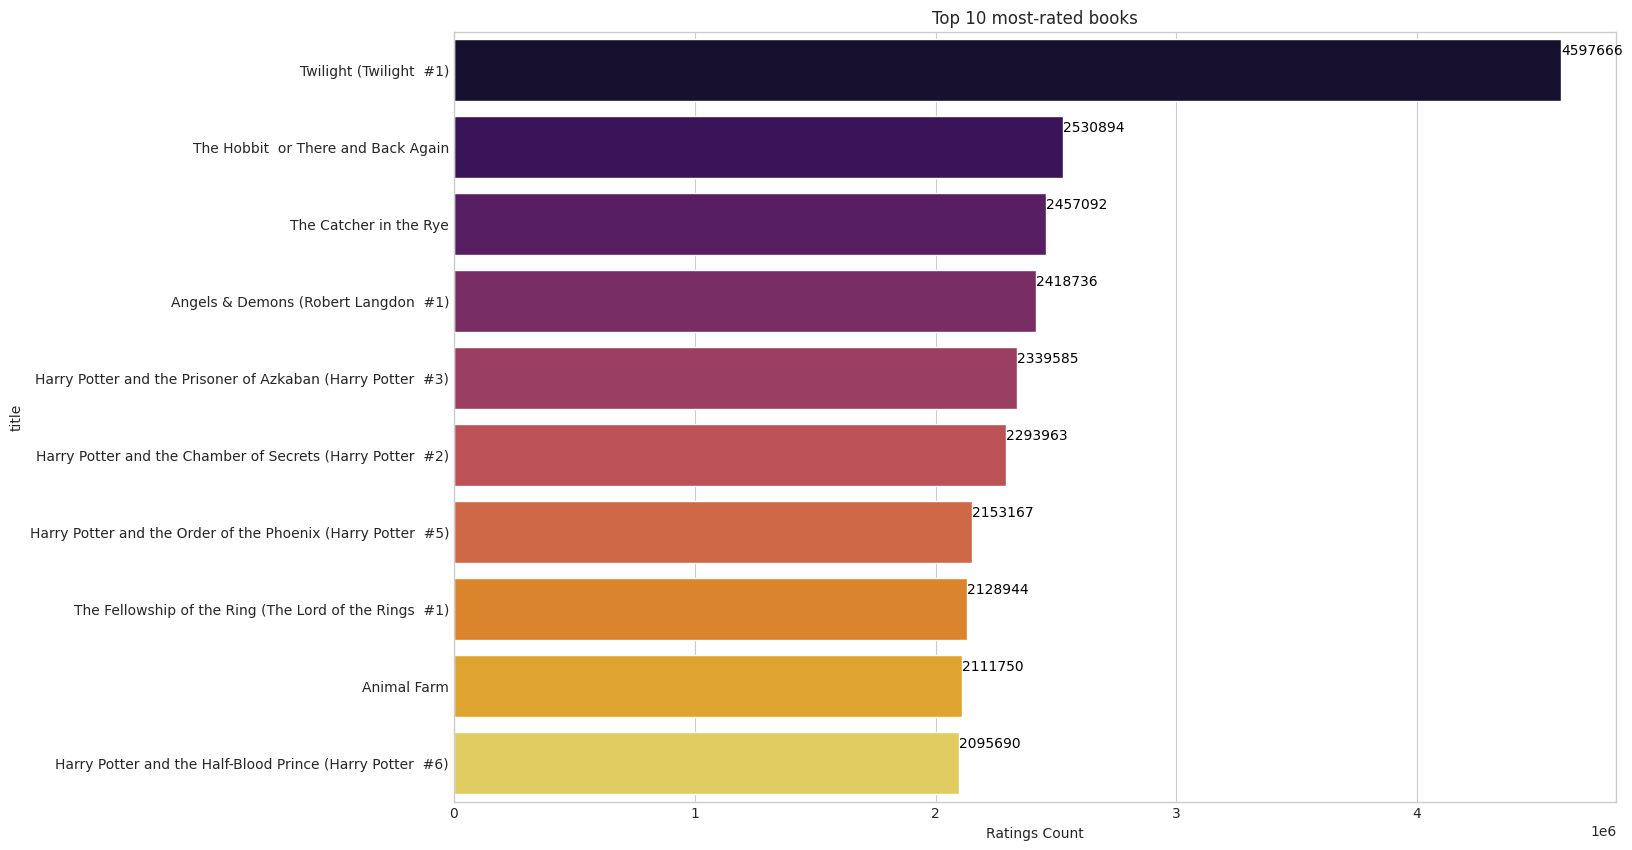

In [97]:
#the top 10 most-rated books

#calculate most rated
most_rated = df.sort_values('ratings_count', ascending=False).head(10).set_index('title')

#plot
plt.figure(figsize=(15,10))
ax = sns.barplot(x=most_rated['ratings_count'], y=most_rated.index, palette='inferno', hue=most_rated.index, legend=False)
ax.set_title("Top 10 most-rated books")
ax.set_xlabel("Ratings Count")

#add totals above the bars for visual clarity
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width() + .2, i.get_y() + .2, str(round(i.get_width())), fontsize=10, color='black')

plt.show()

Twilight stands out as the most reviewed book, with millions of ratings. The Hobbit and The Catcher in the Rye have also received significant attention, each with over two million reviews.

--------------------------------------------------------------------------------
Now let's try to find which columns we should use in feature engineering.

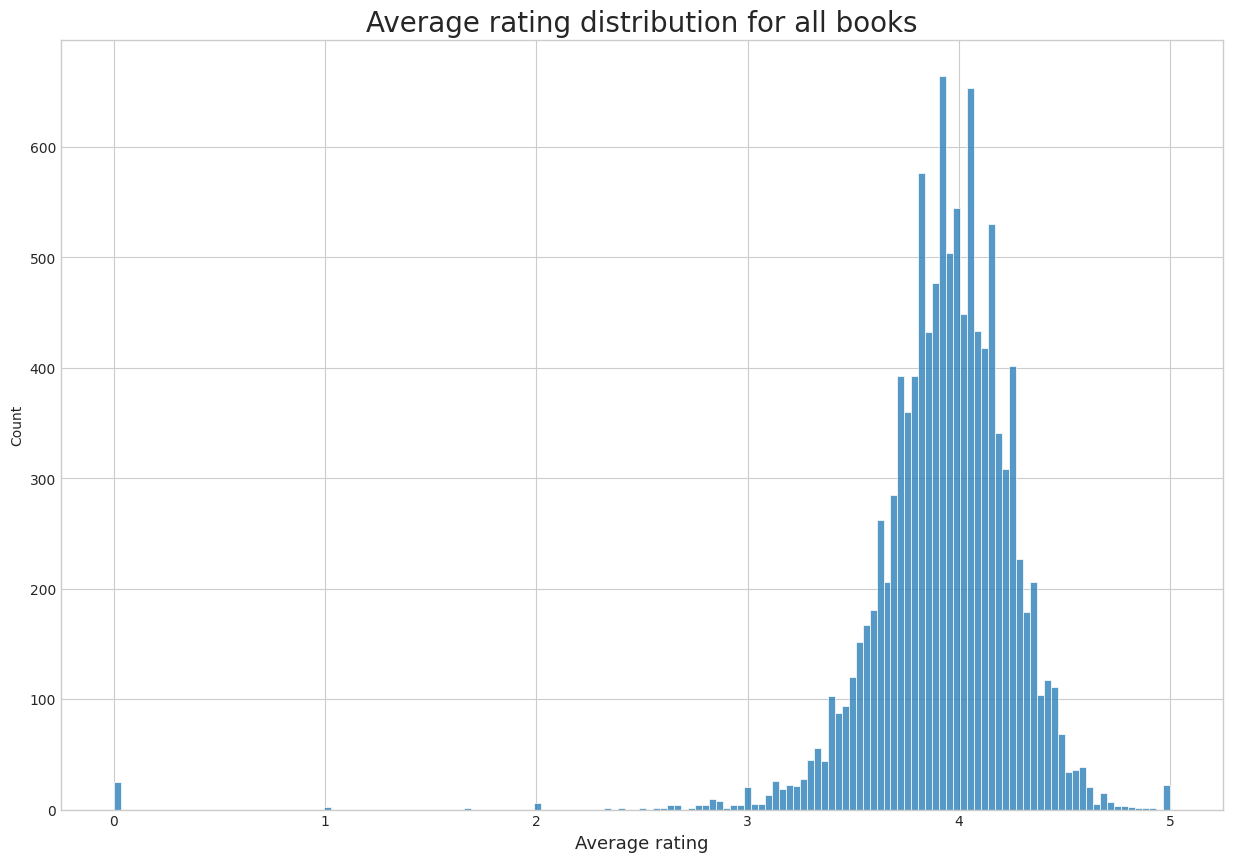

In [44]:
#average rating histogram

#ensure float
df.average_rating = df.average_rating.astype(float)

#plot
fig, ax = plt.subplots(figsize=[15, 10])
sns.histplot(df['average_rating'], ax=ax)
ax.set_title('Average rating distribution for all books', fontsize=20)
ax.set_xlabel('Average rating', fontsize=13)

plt.show()

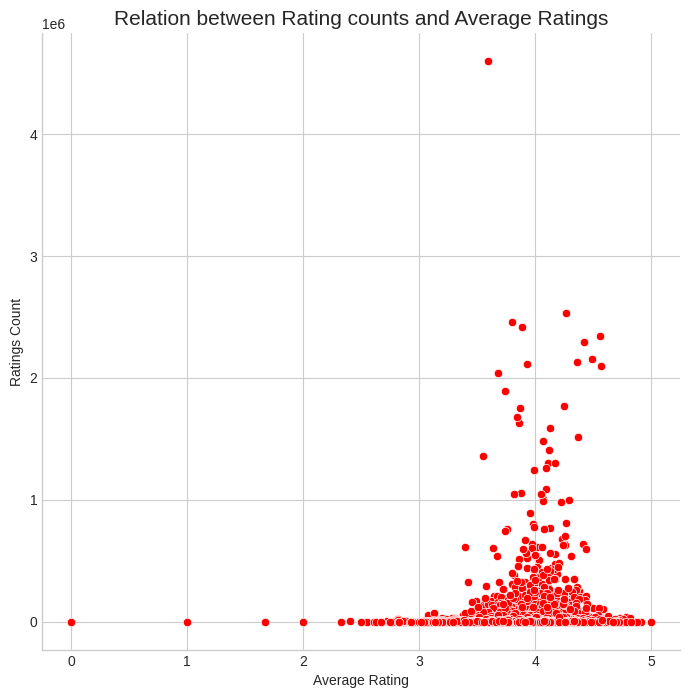

In [20]:
#relation plot1

ax = sns.relplot(data=df, x="average_rating", y="ratings_count", color = 'red', sizes=(100, 200), height=7, marker='o')
plt.title("Relation between Rating counts and Average Ratings",fontsize = 15)
ax.set_axis_labels("Average Rating", "Ratings Count")

Text(0.5, 1.0, 'Relation between Average Rating and Num of Pages')

<Figure size 1500x1000 with 0 Axes>

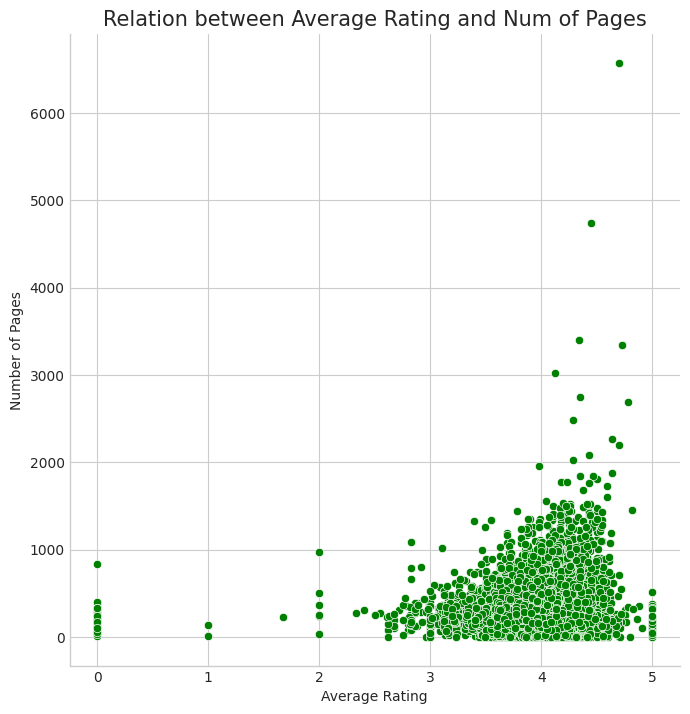

In [95]:
#relation plot2

plt.figure(figsize=(15,10))
ax = sns.relplot(x="average_rating", y="  num_pages", data = df, color = 'green',sizes=(100, 200), height=7, marker='o')
ax.set_axis_labels("Average Rating", "Number of Pages")
plt.title("Relation between Average Rating and Num of Pages",fontsize = 15)

We can see that the number of pages does not really affect the average rating so we can omit it when feature engineering.

In [22]:
#making a copy just in case
df2 = df.copy()

## Data Preprocessing

We are now going to create a new column called ‘rating_between’. We will divide our average rating column into different categories such as rating between 0 and 1, 1 and 2, etc. This will work as one of the features that we will build into our model so that it can make better predictions:

In [23]:
df2.loc[ (df2['average_rating'] >= 0) & (df2['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
df2.loc[ (df2['average_rating'] > 1) & (df2['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
df2.loc[ (df2['average_rating'] > 2) & (df2['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
df2.loc[ (df2['average_rating'] > 3) & (df2['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
df2.loc[ (df2['average_rating'] > 4) & (df2['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

In [24]:
#feature engineering
rating_df = pd.get_dummies(df2['rating_between'])
features = pd.concat([rating_df, df2['average_rating'], df2['ratings_count']], axis=1)
features.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5,average_rating,ratings_count
0,False,False,False,False,True,4.57,2095690
1,False,False,False,False,True,4.49,2153167
2,False,False,False,False,True,4.42,6333
3,False,False,False,False,True,4.56,2339585
4,False,False,False,False,True,4.78,41428


## Recommendation Model

To address potential bias caused by books with more features, we'll standardize the data using Min-Max scaling. This will normalize the values and ensure that all features contribute equally.

In [25]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

Let's use K Nearest Neighbours (KNN) to build our recommendation system.  KNN finds the most similar items (or users) to a given item (or user) based on their feature values. This makes it well-suited for recommending items based on other items. KNN also doesn't require a training phase, making it easy to implement and update with new data.

In [26]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In the function below, we are using fuzzy matching to suggest the closest book if an exact match is not found. Fuzzy matching is a technique used to find approximate matches between strings or data points, even if they have minor differences or variations. It's particularly useful when dealing with data that might contain typos, inconsistencies, or variations in formatting.

In this case, the algorithm we are using for fuzzy matching is the Levenshtein distance. This measures the minimum number of single-character edits (insertions, deletions, or substitutions) needed to transform one string into another.

In [83]:
def find_closest_match(book_name, df2):
    closest_match = process.extractOne(book_name, df2['title'])
    return closest_match[0] if closest_match else None

The BookRecommender function takes a book title and a DataFrame as input. It first attempts to find an exact match for the book title in the DataFrame. If found, it uses KNN to find similar books and returns a DataFrame with their titles, authors, average ratings, and ratings counts. If no exact match is found, it uses a fuzzy matching function to find the closest possible match and recommends books based on that.

In [89]:
def BookRecommender(book_name, df2):
    book_list_name = []
    try:
        #case-insenstive match
        book_id = df2[df2['title'].str.lower() == book_name.lower()].index[0]
        #populate list of recommendations
        for newid in idlist[book_id]:
            recommended_book = df2.loc[newid]
            book_list_name.append({
                'title': recommended_book.title,
                'author': recommended_book.authors,
                'average_rating': recommended_book.average_rating,
                'ratings_count': recommended_book.ratings_count
            })
        return pd.DataFrame(book_list_name)
    #if exact book is not found
    except IndexError:
        #suggest closest match when the book isn't found
        closest_match = find_closest_match(book_name, df2)
        #if a close match is found, create recommendations for the closest match
        if closest_match:
            list2 = []
            print(f"Book '{book_name}' not found. Did you mean '{closest_match}'?")
            print(f"Showing recommendations for {closest_match}")
            list2 = BookRecommender(closest_match, df2)
            return list2
        else:
            print(f"Book '{book_name}' not found in data.")

In [87]:
#example usage with book in system
books = BookRecommender('Black Beauty', df2)
books

,title,author,average_rating,ratings_count
0,Black Beauty,Anna Sewell,3.96,208684
1,Message in a Bottle,Nicholas Sparks,3.96,201488
2,The Good Earth (House of Earth #1),Pearl S. Buck,3.98,200744
3,Odd Thomas (Odd Thomas #1),Dean Koontz,3.97,227884
4,The Namesake,Jhumpa Lahiri,3.99,213178
5,The Art of War,Sun Tzu/Thomas Cleary/Pulat Otkan/Giray Fidan,3.97,235924


In [90]:
#example usage of fuzzy matching
books = BookRecommender('Black Bety', df2)
books

Book 'Black Bety' not found. Did you mean 'Black Beauty'?
Showing recommendations for Black Beauty


,title,author,average_rating,ratings_count
0,Black Beauty,Anna Sewell,3.96,208684
1,Message in a Bottle,Nicholas Sparks,3.96,201488
2,The Good Earth (House of Earth #1),Pearl S. Buck,3.98,200744
3,Odd Thomas (Odd Thomas #1),Dean Koontz,3.97,227884
4,The Namesake,Jhumpa Lahiri,3.99,213178
5,The Art of War,Sun Tzu/Thomas Cleary/Pulat Otkan/Giray Fidan,3.97,235924
